# Fouille de données / Data Mining
## Summer 2023 - Fouille de réseaux sociaux / Mining of social networks

This lab was made as part of Polytechnique Montreal's class on Data Mining. The course's ID not omitted to limit plagiarism (public repo).

Team members
- Marco Mudenge
- Matthieu Souttre



## Introduction et objectifs

### Importation des différents modules

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install requests

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import linear_model

### Téléchargement des données

In [3]:
import requests

response = requests.get(
    "https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/export?format=csv&gid=1150341366"
)
assert response.status_code == 200, "Wrong status code"
# convert the csv to a pandas dataframe
with open("data.csv", "w") as f:
    f.write(response.text)

df = pd.read_csv("data.csv")


Le but de ce notebook est d'effectuer le prétraitement du dataset [HousePricePrediction](https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/edit#gid=1150341366) qui pourra être par la suite être utilisé pour entraîner un modèle de prédiction de prix de maisons.

## Préparation des données

Plusieurs étapes sont nécessaires pour préparer un dataset pour la fouille des données
- **Nettoyage des données** : 
    - Suppression des attributs inutiles
    - Gestion des valeurs manquantes
    - Gestion des valeurs aberrantes
- **Transformation des données** : 
    - Encodage des données
    - Normalisation des données
- **Sélection des attributs** : 
    - Suppression des attributs les plus fortement corrélés

## Sommaire

1. [Première observation des données](#1.-Première-observation-des-donnees)
2. [Nettoyage des données](#2.-Nettoyage-des-données)
   1. [Suppression des attributs inutiles](#2.1.-Suppression-des-attributs-inutiles)
   2. [Gestion des valeurs manquantes](#2.2.-Gestion-des-valeurs-manquantes)
   3. [Détection des valeurs aberrantes](#2.3.-Détection-des-valeurs-aberrantes)
3. [Transformation des données](#3.-Transformation-des-données)
   1. [Encodage des attributs de type `object`](#3.1.-Encodage-des-attributs-de-type-object)
   2. [Normalisation des données](#3.2.-Normalisation-des-données)
4. [Sélection des attributs](#4.-Sélection-des-variables)
   1. [Suppression des attributs corrélées](#4.1.-Suppression-des-variables-corrélées)
5. [Récapitulatif des procédés](#5.-Récapitulatif-des-prétraitements)
6. [Entrainement d'un modèle de régression linéaire](#6.-Récapitulatif-des-prétraitements)
    1. [Rappel du concept](#6.1.-Rappel-concept)
    2. [Application](#6.2.-Application)
7. [Bonus : méthode des écarts interquartiles ou IRQ](#7.-Récapitulatif-des-prétraitements)

## 1. Exploration des données (1 point)

Nous vous avons fourni le fichier *data.csv* avec l'exécution de la deuxième cellule. Il contient l'ensemble des données. Chaque ligne contient les données d'une vente. La description des attributs du dataset est la suivante:

| # | Feature Name | Description |
|---|--------------|-------------|
| 1 | Id           | Numéro de vente / To count the records. |
| 2 | MSSubClass   | Type de logement / Identifies the type of dwelling involved in the sale. |
| 3 | MSZoning     | Zonage / Identifies the general zoning classification of the sale. |
| 4 | LotArea      | Superficie du logement / Lot size in square feet. |
| 5 | LotConfig    | Configuration du logement / Configuration of the lot |
| 6 | BldgType     | Type de logement / Type of dwelling |
| 7 | OverallCond  | Etat général / Rates the overall condition of the house |
| 8 | YearBuilt    | Année de contruction / Original construction year |
| 9 | YearRemodAdd | Année de rénovation / Remodel date (same as construction date if no remodeling or additions). |
| 10| Exterior1st  | Type de revêtement extérieur / Exterior covering on house |
| 11| BsmtFinSF2   | Surface de vie / Type 2 finished square feet. |
| 12| TotalBsmtSF  | Surface totale de la base / Total square feet of basement area |
| 13| SalePrice    | Prix de vente à prédire / To be predicted |

On visualise le dataset pour avoir une idée de ce qu'il contient et des prétraitements à effectuer.

### 1.1 - Question 1 (0.5 point)

**Combien d'éléments contient le dataset ? Quelles sont les types des attributs du dataset ?**

In [4]:
N = df.shape[0]
print(f"Ce dataset contient {N} éléments")

Ce dataset contient 2919 éléments


In [5]:
# Types des attributs du dataset
df.dtypes

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
LotConfig        object
BldgType         object
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
Exterior1st      object
BsmtFinSF2      float64
TotalBsmtSF     float64
SalePrice       float64
dtype: object

Ce dataset contient des attributs de type int, object et float.

Toutefois, l'attribut MSSubClass, bien que de type int, correspond à un type de logement qui n'engendre pas nécessairement une relation d'ordre, donc cela pourrait correspondre à un attribut de type catégorique.

### 1.2 - Question 2 (0.5 point)

**Quelles sont les valeurs uniques des attributs de type `object` ?**

In [6]:
# Affiche le nombre de valeurs uniques pour chaque attribut object
obj_df = df.select_dtypes(include=["object"])

# Affiche les valeurs uniques pour chaque attribut object
for col in obj_df.columns:
    print(
        f"{col} ({obj_df[col].nunique()} valeurs uniques) : {obj_df[col].unique()}")

MSZoning (5 valeurs uniques) : ['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
LotConfig (5 valeurs uniques) : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
BldgType (5 valeurs uniques) : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Exterior1st (15 valeurs uniques) : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]


## 2. Nettoyage des données (7 points)

### 2.1 Suppression des attributs inutiles

### 2.1.1 - Question 3 (1 point)

**Pourquoi on peut supprimer l'attribut `Id` dans le cas de ce TP? Effectuez cette suppression.**

L'attribut sert à indexer les données. Il n'a donc pas d'utilité.

In [7]:
df.drop(columns="Id", inplace=True)

### 2.2 Gestion des valeurs manquantes

Pour gérer les valeurs manquantes, plusieurs solutions s'offrent à nous :
- Remplacer par la valeur la plus fréquente (le mode)
- Remplacer par la valeur moyenne/médiane
- Suppression des lignes contenant des valeurs manquantes

Pour ce TP, nous utiliserons la dernière option car nous avons peu de valeurs manquantes.

#### 2.2.1 - Question 4 (0.5 point)

**Quels attributs contiennent des valeurs manquantes ?**

In [8]:
df.isna().sum()

MSSubClass         0
MSZoning           4
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        1
BsmtFinSF2         1
TotalBsmtSF        1
SalePrice       1459
dtype: int64

L'attribut SalePrice a 1459 valeurs manquantes, l'attribut MSZoning en a 4, tandis que les attributs TotalBsmtSF, Exterior1st et BsmtFinSF2 en ont 1 chacun.

#### 2.2.2 - Question 5 (0.5 point)

On peut alors gérer les valeurs manquantes colonne par colonne. L'attribut `SalePrice` n'est pas pris en considération car les valeurs manquantes sont justement les valeurs que nous voulons prédire.

**Supprimer les lignes contenant les valeurs manquantes. Implémentez la fonction `delete_missing_values` qui retire ces données**.

In [9]:
def delete_missing_values(dataset):
    """
    This function deletes row whom a value is missing.

    :param dataset: ensemble des données
    :return:
      dataset traitée
    """
    dataset.dropna(subset=df.columns.difference(
        ["SalePrice"]), axis=0, inplace=True)
    return dataset

In [10]:
df = delete_missing_values(df)

In [11]:
# Verification
df.isna().sum()

MSSubClass         0
MSZoning           0
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        0
BsmtFinSF2         0
TotalBsmtSF        0
SalePrice       1453
dtype: int64

Les données manquantes pour la colonne `SalePrice` sont celles du dataset de test. On laisse donc ces valeurs manquantes car on veut appliquer le même prétraitement sur les données de test.

### 2.2.3 - Question 6 (2.5 point)

On veut néanmoins que les données d'entrainement suivent une distribution gaussienne.

**Implémenter le fonction `plot_hist`. Cette fonction doit permettre d'afficher la distribution des valeurs de l'attribut `SalePrice` ainsi que la loi normale de même moyenne et variance.**

In [12]:
import scipy

In [13]:
def plot_hist(prices, log):
    """
    Affiche la distribution du prix de vente

    :param prices: ensemble des prix.
    """
    mean = prices.mean()
    std = prices.std()
    normal_x = np.linspace(prices.min(), stop=prices.max(), num=500)
    normal_y = scipy.stats.norm.pdf(normal_x, mean, std)
    plt.plot(normal_x, normal_y)
    plt.hist(x=prices, density=True, bins=30)
    if log == True:
        plt.xlabel("log(SalePrice) [CAD]")
    else:
        plt.xlabel("SalePrice [CAD]")
    plt.ylabel("Densité [-]")
    plt.show()

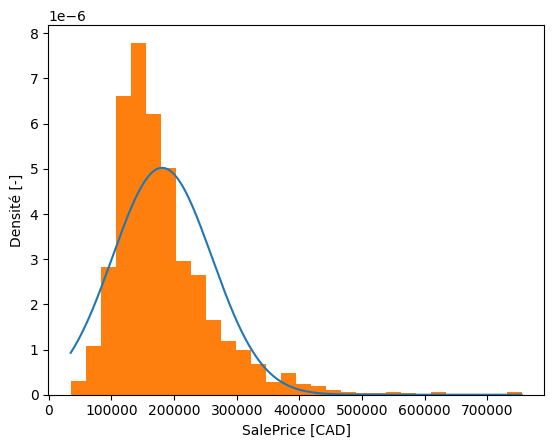

In [14]:
plot_hist(df["SalePrice"], log=False)

Vous devez obtenir une distribution des valeurs de `SalePrice` proches d'une distribution normale mais légèrement asymétrique. On peut alors appliquer une transformation logarithmique pour approcher d'une distribution normale symétrique.

**Effectuer cette transformation sur notre ensemble de données.**

In [15]:
df["SalePrice"] = df["SalePrice"].apply(lambda x: np.log(x))

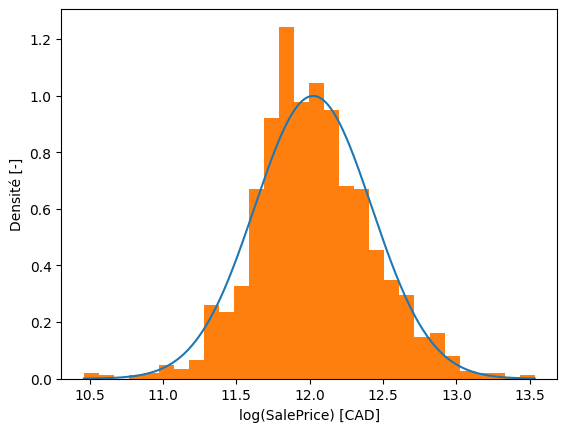

In [16]:
# Graphe mis à jour avec log(SalePrice)
plot_hist(df["SalePrice"], log=True)

### 2.3 Détection des valeurs aberrantes

En pratique, la méthode de détection d'une valeur aberrante nécessite de se poser les questions suivantes:
- Quelles valeurs seraient incohérentes pour chaque colonne ?
- Quelles valeurs peuvent être problématiques pour l'utilisation de ces données ? Exemple: pour une régression linéaire, on préfère avoir des valeurs distribuées suivant une loi normale.

Avec ces éléments, on peut:
- Fixer des seuils de tolérance pour les valeurs aberrantes
- Utiliser des algorithmes de détection de valeurs aberrantes (ex: clustering, IRQ, [QTest](https://plotly.com/python/v3/outlier-test/), ...)

A noter que suivant les méthodes, les valeurs détectées comme aberrantes peuvent être différentes. 

La méthode IRQ fait l'objet d'une partie bonus, en fin de ce notebook.

### 2.3.1 Question 7 (2.5 point)

Ici comme nous allons réaliser une régression linéaire, nous allons visuellement voir si certains points s'écartent franchement de la droite de régression. 

On sait que l'on veut effectuer une régression linéaire pour prédire `SalePrice`. On peut donc visualiser les valeurs de chaque attribut en fonction de `SalePrice` pour détecter la présence de valeurs aberrantes.

**Implémenter la fonction `plot_line`. Elle doit permettre de visualiser la relation entre un attribut donné et `SalePrice`.**

In [17]:
def plot_line(attr):
    """
    Affiche la relation entre attr et SalePrice

    :param attr: attribut à comparer à SalePrice
    """
    df_copy = df.copy(deep=True)
    # drops NaN values that are not useful for the regression
    df_copy.dropna(inplace=True)
    regr = linear_model.LinearRegression()  # trains the regression model
    # needs to reshape for applying sklearn fit function
    x = np.array(df_copy[attr]).reshape(-1, 1)
    y = np.array(df_copy["SalePrice"]).reshape(-1, 1)
    regr.fit(x, y)  # fits the regression model
    SalePrice_pred = regr.predict(x)  # linear regression curve y values

    ### Plotting ###
    plt.plot(df_copy[attr], df_copy["SalePrice"],
             ".", ls="", label="Data", alpha=0.5)
    plt.plot(df_copy[attr], SalePrice_pred,
             linewidth=3, label="Linear regression")
    plt.ylabel("log(SalePrice)")
    plt.xlabel(attr)
    plt.legend()
    plt.show()

**Afficher les relations de tous les attributs avec `SalePrice`. Peut-on y déceler des valeurs aberrantes ?**

Nous sommes contraints d'exclure les données de type "objet" pour tracer les régressions linéaires. De manière générale, il est compliqué de repérer visuellement les valeurs aberrantes de cette manière. Toutefois, on peut repérer les outliers extrême, par exemple pour l'attribut TotalBsmtSF.

De plus, cette approche n'est pas nécessairement pertinente pour l'attribut MSSubClass : bien qu'il soit de type int, il n'y a pas de forcément relation d'ordre entre les valeurs et cet attribut qui pourrait donc s'apparenter plutôt à un output de type catégorique.

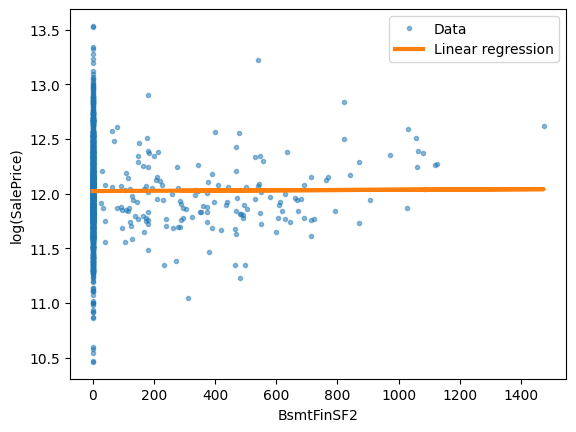

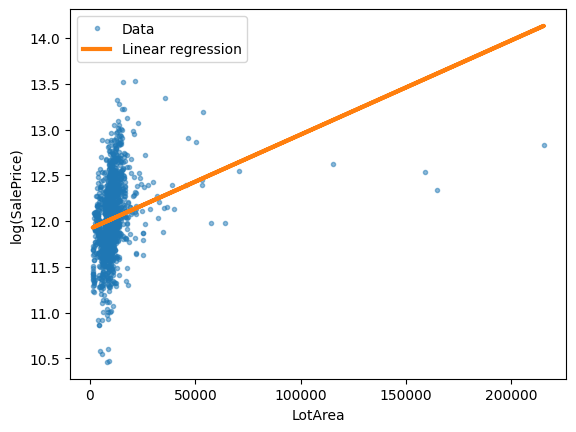

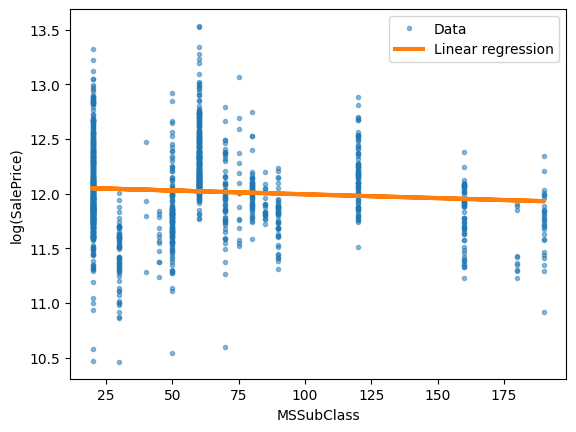

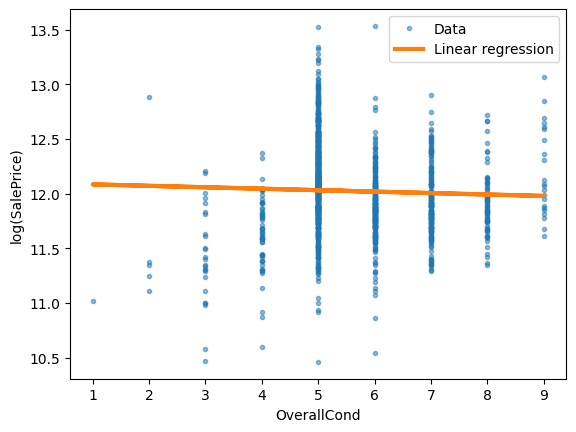

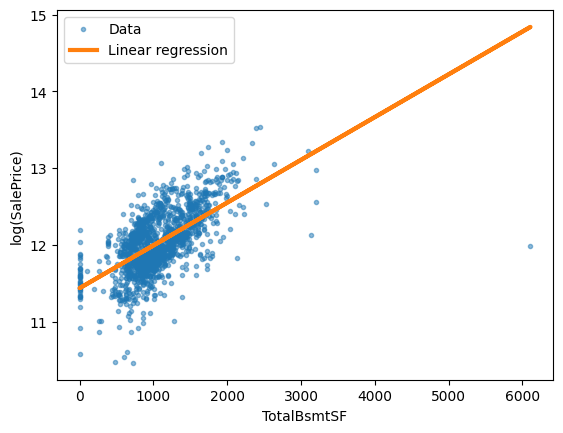

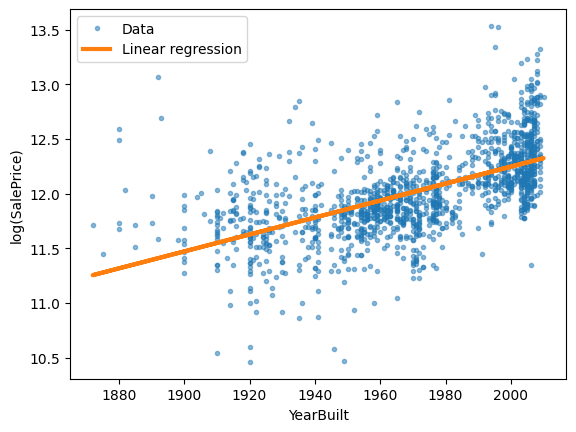

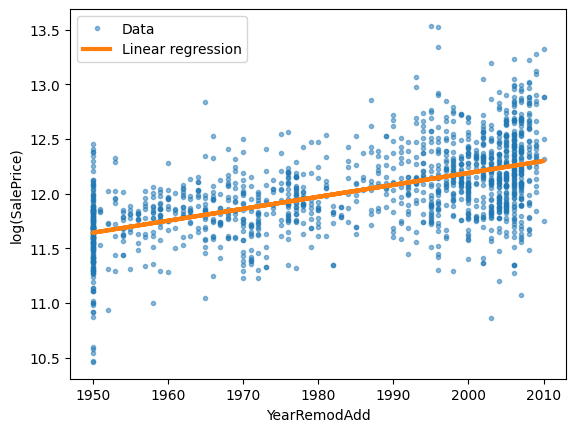

In [18]:
# we exclude columns that are categorical
for col in list(
    df.columns.difference(
        ["MSZoning", "LotConfig", "BldgType", "Exterior1st", "SalePrice"]
    )
):
    plot_line(col)

## 3. Transformation des données (2.5 points)

### 3.1 Encodage des attributs de type `object`

Les attributs de type `object` étant catégoriques (voire partie 1), on peut effectuer un `one hot encoding` de ces attributs. `Pandas` permet d'effectuer cela avec la fonction `get_dummies()`. Cela nous permettra d'obtenir un dataset contenant uniquement des attributs de type `int` ou `float`.


#### 3.1.1 Question 8 (1.5 point)

**Encodez les attributs de type `object` avec un `one hot encoding`**

In [19]:
object_attributes = ["MSZoning", "LotConfig", "BldgType", "Exterior1st"]
columns_to_normalize = df.columns.difference(object_attributes)

In [20]:
for col in object_attributes:
    one_hot = pd.get_dummies(df[col])  # hot encoding of the column
    df = df.drop(col, axis=1)  # drop object column
    df = df.join(one_hot)  # append hot encoding columns

In [21]:
df.head()

,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,C (all),FV,...,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing
0,60,8450,5,2003,2003,0.0,856.0,12.247694,False,False,...,False,False,False,False,False,False,False,True,False,False
1,20,9600,8,1976,1976,0.0,1262.0,12.109011,False,False,...,False,False,False,True,False,False,False,False,False,False
2,60,11250,5,2001,2002,0.0,920.0,12.317167,False,False,...,False,False,False,False,False,False,False,True,False,False
3,70,9550,5,1915,1970,0.0,756.0,11.849398,False,False,...,False,False,False,False,False,False,False,False,True,False
4,60,14260,5,2000,2000,0.0,1145.0,12.429216,False,False,...,False,False,False,False,False,False,False,True,False,False


### 3.2 Normalisation des données

Pour faciliter l'entraînement du modèle, on peut normaliser les données. `sklearn` permet d'effectuer cela avec les fonctions suivantes :

*   `StandardScaler()` normalise les données en soustrayant la moyenne et en divisant par l'écart-type
*   `MinMaxScaler()` normalise les données en les ramenant entre 0 et 1.

Dans la suite de ce TP, nous utiliserons la fonction `StandardScaler()`.

In [22]:
# A utiliser dans la partie 6.2
mu_sale_price = df["SalePrice"].mean()
sigma_sale_price = df["SalePrice"].std()

#### 3.2.1 Question 9 (1 point)

**Implémenter la fonction `normalize`. Elle doit réaliser la normalisation des données.**

In [23]:
def normalize(dataset):
    """
    Normalise les données du dataset.

    :param dataset: ensemble des données
    :return:
      dataset traitée
    """
    x = dataset.values
    scaler = preprocessing.StandardScaler()
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=dataset.columns)

In [24]:
df = normalize(df)

In [25]:
df.head()

,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,C (all),FV,...,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing
0,0.066066,-0.215504,-0.511162,1.044791,0.895701,-0.293353,-0.447678,0.560068,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
1,-0.874430,-0.068656,2.194499,0.152334,-0.398557,-0.293353,0.475862,0.212764,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,2.342595,-0.286522,-0.026212,-0.122403,-0.736819,-0.404152,-0.140004
2,0.066066,0.142038,-0.511162,0.978683,0.847765,-0.293353,-0.302095,0.734046,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004
3,0.301189,-0.075041,-0.511162,-1.863958,-0.686170,-0.293353,-0.675151,-0.437382,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,-0.736819,2.474318,-0.140004
4,0.066066,0.526395,-0.511162,0.945629,0.751894,-0.293353,0.209719,1.014651,-0.09304,-0.223848,...,-0.212626,-0.422936,-0.018531,-0.426877,-0.286522,-0.026212,-0.122403,1.357185,-0.404152,-0.140004


## 4. Sélection des attributs (4 points)

### 4.1 Suppression des attributs corrélées

Pour améliorer la qualité de la prédiction, nous devons prendre en compte la corrélation entre attributs. L'objectif est donc de supprimer les attributs les plus fortement corrélées entre eux.

Pour ce faire, vous disposez des fonctions suivantes 

* `corr()` de `Pandas` qui calcule la matrice de corrélation
* `heatmap()` de `seaborn` qui permet de visualiser la matrice de corrélation


#### 4.1.1 Question 10 (2.5 point)

**Implémenter la fonction `display_corr_matrix`. Elle doit permettre d'afficher la matrice de corrélation entre les différents attributs de nos données normalisation des données.**

In [26]:
def display_corr_matrix(dataset):
    """
    Créer et affiche la matrice de corrélation des attributs liés au dataset.

    :param dataset: ensemble des données
    """

    corr_matrix = dataset.corr(method="pearson")
    sns.heatmap(data=corr_matrix, cmap="vlag")

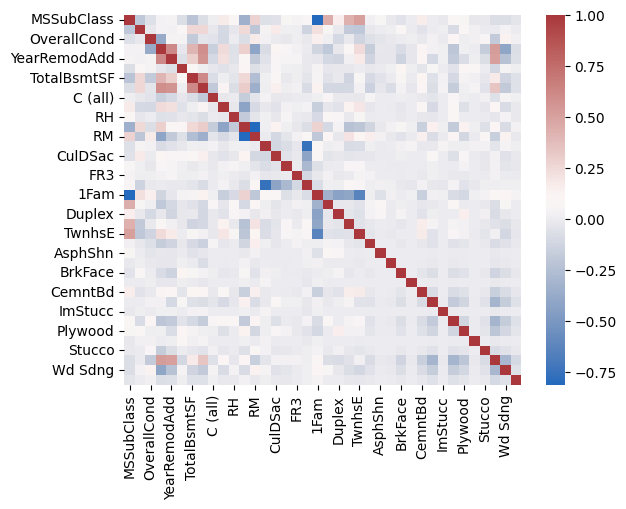

In [27]:
display_corr_matrix(df)

#### 4.1.2 Question 11 (1.5 point)

On peut alors choisir de supprimer les attributs qui sont fortement corrélées entre eux en définissant un seuil. Fixons ce seuil à 0.7.

**Quels sont les attributs fortement correlés selon le critère ci-dessus ? Supprimez ces attributs et affichez la nouvelle matrice de corrélation.**

In [28]:
df_corr_matrix = df.corr(method="pearson")

In [29]:
seuil = 0.7
print("Correlated attributes:")
for col in df_corr_matrix.columns:
    attr = df_corr_matrix[
        (df_corr_matrix[col] >= seuil) | (df_corr_matrix[col] <= -1.0 * seuil)
    ].index[0]
    if attr == col:
        pass
    else:
        print(f"{attr} and {col}")

Correlated attributes:
RL and RM
Corner and Inside
MSSubClass and 1Fam


In [30]:
df = df.drop(["RM", "Inside", "1Fam"], axis=1)

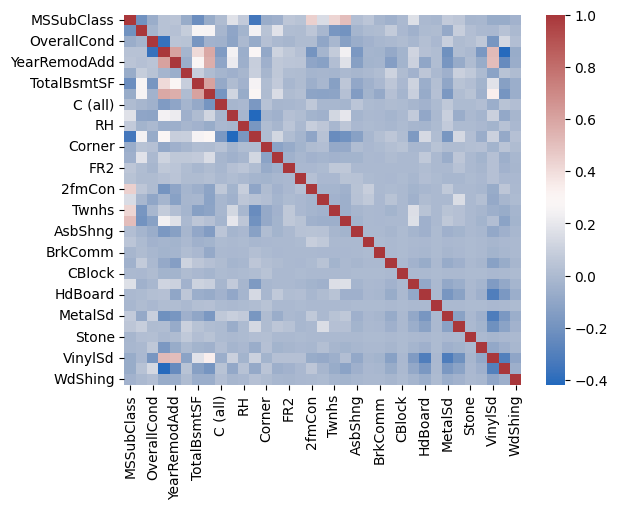

In [31]:
display_corr_matrix(df)

## 5. Récapitulatif des prétraitements

<img src=" 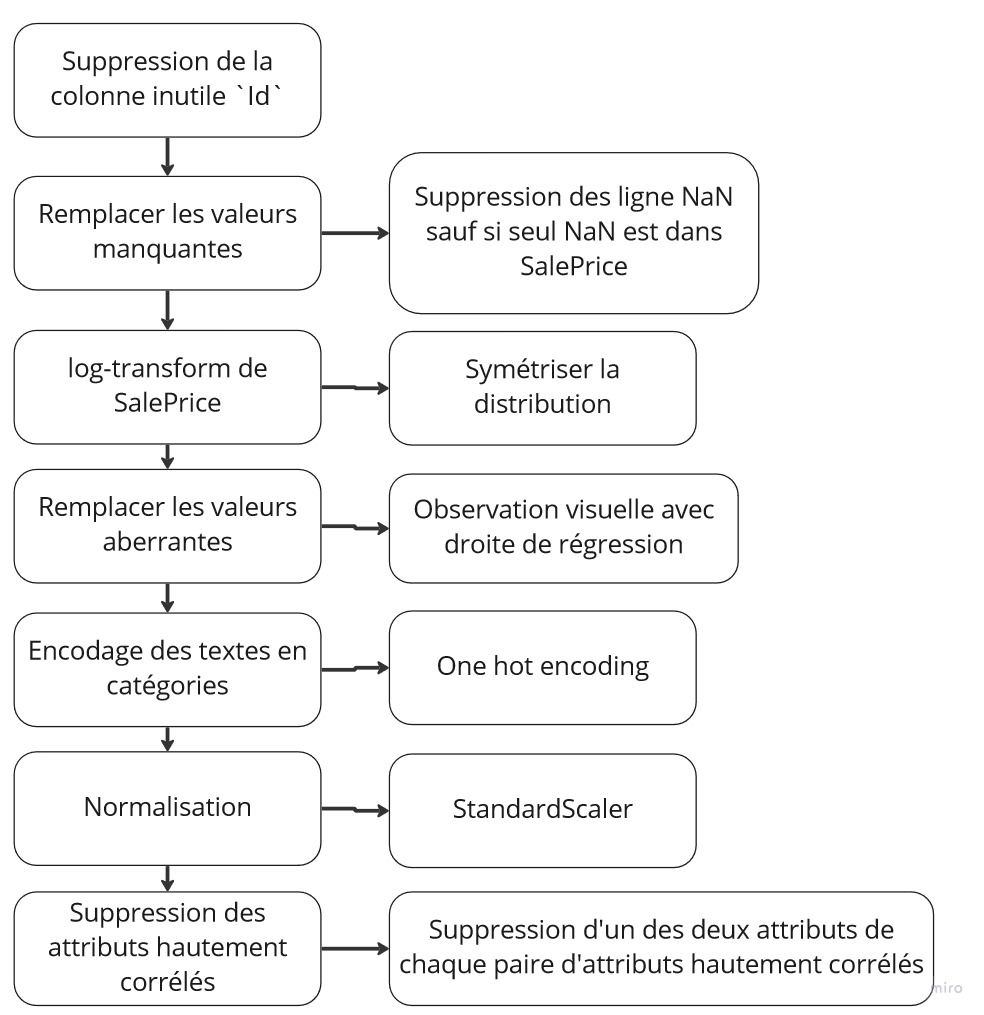" height="600px">

## 6. Entrainement d'un modèle de régression linéaire (5.5 points)

### 6.1 Rappel du concept

La régression linéaire consiste à trouver une fonction affine qui minimise la somme des carrés des erreurs. La fonction affine est définie par la formule suivante :
$$ f(x) = \beta_0 + \beta_1 x $$
Nous tentons de trouver les paramètres $\beta_0$ et $\beta_1$ qui minimisent $\sum_{i=1}^n (f(x_i) - y_i)^2=||y-X\beta||^2$ où $X$ est la matrice des données fournies au modèle et $y$ le vecteur des `SalePrice`.

On veut trouver le minimum de cette fonction. On va utiliser `RidgeRegression` de `sklearn` pour trouver les paramètres $\beta_0$ et $\beta_1$. Ce module utilise la méthode des moindres carrés (`numpy.linalg.lstsq`) pour trouver les paramètres $\beta_0$ et $\beta_1$.

### 6.2 Application

#### 6.2.1 Question 12 (1 point)

Après avoir effectué le prétraitement, on peut commencer par séparer les données en un ensemble d'entraînement et un ensemble de test. Pour cela, les 1460 premières lignes contiennent les données d'entrainement. On peut ainsi séparer les données en deux ensembles.

**Compléter la structure suivante afin de diviser les données en deux sous-ensembles.**

In [32]:
data_train = {
    "x": df[df.columns.difference(["SalePrice"])][:1460],
    "y": df["SalePrice"][:1460],
    "df": df,
}
data_pred = {"x": df[df.columns.difference(["SalePrice"])][1460:], "df": df}

#### 6.2.2 Question 13 (1.5 point)

Une fois cette scission faite, on peut utiliser `RidgeRegression` pour effectuer la régression linéaire avec pénalisation de la norme L2.

**Compléter la fonction `ridge_regression`. Elle doit implémenter l'ensemble de la régression.**

*Pour cette question, vous devez retourner les coefficients de la regression linéaire. De plus, ce fonction doit modifier le paramètre `data_pred` en y ajoutant les valeurs prédites. Il est aussi nécéssaire de prendre en compte certaines modifications effectuées lors de la transformation des données*

In [33]:
from sklearn.linear_model import Ridge

In [34]:
def ridge_regression(data_train, data_pred):
    """
    Réaliser la prédiction selon la régression de Rigde.

    :param data_train: données d'entrainement
    :param data_pred: données de prédiction
    :return:
      coefficients de la régression
    """

    clf = Ridge(alpha=1.0)
    clf.fit(data_train["x"], data_train["y"])
    data_pred["y"] = clf.predict(data_pred["x"])
    return clf.coef_

In [35]:
# print Nan values
print(data_train["x"].isna().sum())

2fmCon          0
AsbShng         0
AsphShn         0
BrkComm         0
BrkFace         0
BsmtFinSF2      0
C (all)         0
CBlock          0
CemntBd         0
Corner          0
CulDSac         0
Duplex          0
FR2             0
FR3             0
FV              0
HdBoard         0
ImStucc         0
LotArea         0
MSSubClass      0
MetalSd         0
OverallCond     0
Plywood         0
RH              0
RL              0
Stone           0
Stucco          0
TotalBsmtSF     0
Twnhs           0
TwnhsE          0
VinylSd         0
Wd Sdng         0
WdShing         0
YearBuilt       0
YearRemodAdd    0
dtype: int64


In [36]:
# Coefficients de la régression
ridge_regression(data_train, data_pred)

array([-0.22813011, -0.01190346,  0.00927336, -0.03741409,  0.07287274,
       -0.02927581, -0.08726649, -0.00395931,  0.01668402,  0.0159271 ,
        0.02526455, -0.16223763, -0.00760963,  0.00811763,  0.07388991,
       -0.05328035,  0.00690363,  0.07257981,  0.49303114,  0.00559645,
        0.12064271, -0.01091519,  0.02269243,  0.10756624,  0.02408781,
        0.01492032,  0.45104385, -0.30492828, -0.34915403, -0.00294079,
        0.01486078,  0.00605802,  0.34265054,  0.20108299])

In [37]:
# Valeurs prédites normalisées (Log(SalePrice))
data_pred["y"]

array([-0.6926394 , -0.13946367,  0.5364081 , ...,  0.21286808,
        0.52157411,  0.3410096 ])

In [38]:
# Valeurs prédites en CAD
np.exp((data_pred["y"]*sigma_sale_price) + mu_sale_price)

array([126421.24171582, 157682.98579599, 206554.6111299 , ...,
       181512.79973741, 205334.29820273, 191045.67673184])

#### 6.2.3 Question 14 (1 point)

**Comparer la distribution des données prédites avec celles d'entrainement.**

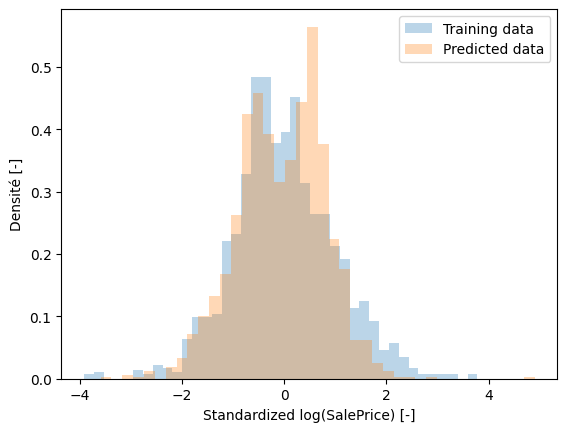

In [39]:
plt.hist(data_train["y"], alpha=0.3, bins=40,
         density=True, label="Training data")
plt.hist(data_pred["y"], alpha=0.3, bins=40,
         density=True, label="Predicted data")
plt.xlabel("Standardized log(SalePrice) [-]")
plt.ylabel("Densité [-]")
plt.legend()
plt.show()

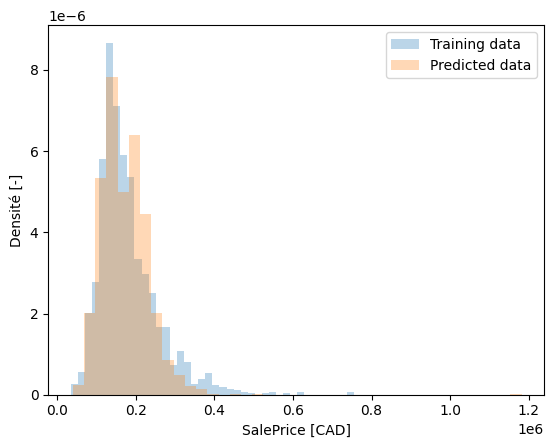

In [40]:
y_train_raw = np.exp((data_train["y"]*sigma_sale_price) + mu_sale_price)
y_test_raw = np.exp((data_pred["y"]*sigma_sale_price) + mu_sale_price)

plt.hist(y_train_raw, alpha=0.3, bins=40,
         density=True, label="Training data")
plt.hist(y_test_raw, alpha=0.3, bins=40,
         density=True, label="Predicted data")
plt.xlabel("SalePrice [CAD]")
plt.ylabel("Densité [-]")
plt.legend()
plt.show()

#### 6.2.4 Question 15 (2 points)

Une fois la prédiction obtenue, on peut maintenant mesurer l'importance de chaque attribut dans la prédicition.

**Quels sont les dix attributs ayant le plus d'impact dans la prédiction ?**


Un facteur de valeur numérique élevée dans la regression est synonyme d'un grand impact dans la prédiction. Nous allons donc générer les 10 attributs avec les plus grandes valeurs absolues.

In [41]:
reg_factors = pd.DataFrame(
    ridge_regression(data_train, data_pred), columns=["Regression factor"]
)
reg_factors.index = df.columns.difference(["SalePrice"])
reg_factors

,Regression factor
2fmCon,-0.228130
AsbShng,-0.011903
AsphShn,0.009273
BrkComm,-0.037414
BrkFace,0.072873
BsmtFinSF2,-0.029276
C (all),-0.087266
CBlock,-0.003959
CemntBd,0.016684
Corner,0.015927


In [42]:
# 10 facteurs ayants le plus d'impact
reg_factors.sort_values("Regression factor", key=abs, ascending=False).head(10)

,Regression factor
MSSubClass,0.493031
TotalBsmtSF,0.451044
TwnhsE,-0.349154
YearBuilt,0.342651
Twnhs,-0.304928
2fmCon,-0.228130
YearRemodAdd,0.201083
Duplex,-0.162238
OverallCond,0.120643
RL,0.107566


## 7. Bonus : méthode des écarts interquartiles ou IRQ (1 point)

On peut également détecter les valeurs aberrantes en affichant un boxplot de chaque colonne. `Plotly` considère les valeurs aberrantes comme des outliers si elles sont situées en dehors de l'intervalle [Q1 - α * IQR, Q3 + α * IQR] où 
* Q1 et Q3 sont les quantiles 25% et 75%, 
* IQR l'intervalle interquartile (Q3 - Q1)
* α le facteur d'ajustement.

On exclut `SalePrice` car les seules valeurs manquantes de cet attribut sont celles du dataset de test.

### 7.1 Question A (0.75 point)

**A quelle valeur fixer le facteur d'ajustement α ? Combien y-a-t-il alors de données aberrantes pour chaque attribut ?**

Dans plotly, la valeur par défaut du facteur d'ajustement est de 1.5. Pour cette valeur, l'écart entre la médiane et les bornes est de 2.698σ.


In [45]:
import plotly.graph_objects as go


def get_bounds(data, alpha=1.5):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    median = data.quantile(0.5)
    iqr = q3 - q1
    lower_bound = q1 - alpha * iqr
    upper_bound = q3 + alpha * iqr
    return q1, median, q3, lower_bound, upper_bound


def plot_outliers(data, alpha=1.5):
    """
    Affiche le boxplot des données avec les outliers
    pour un facteur d'ajustement alpha donné.

    :param data: les données pour un attribut
    :param alpha: facteur d'ajustement
    """

    q1, median, q3, lower_bound, upper_bound = get_bounds(data, alpha)

    outliers = data[(data < lower_bound) | (data > upper_bound)]

    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=[data.values],
            name=data.name,
            boxpoints="outliers",
            q1=np.array(q1),
            median=np.array(median),
            q3=np.array(q3),
            lowerfence=np.array(lower_bound),
            upperfence=np.array(upper_bound),
            marker=dict(color="indianred", outliercolor="indianred"),
            line_color="rgb(107,174,214)",
            hoverinfo="y",
        )
    )

    fig.update_layout(
        title_text="{} <br><sup>Numbers of outliers : {} </sup>".format(
            data.name, len(outliers)
        ),
        xaxis=dict(
            showticklabels=False,
        ),
    )

    fig.show()

def plot_outliers_with_matplotlib(data, alpha=1.5):
    """
    Affiche le boxplot des données avec les outliers
    pour un facteur d'ajustement alpha donné.

    :param data: les données pour un attribut
    :param alpha: facteur d'ajustement
    """
    q1, median, q3, lower_bound, upper_bound = get_bounds(data, alpha)
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    plt.boxplot(data, showfliers=True)
    plt.title(
        f"{data.name} \n Numbers of outliers : {len(outliers)}")
    plt.show()

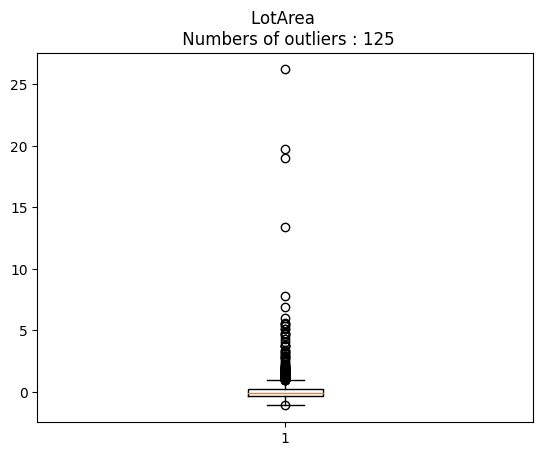

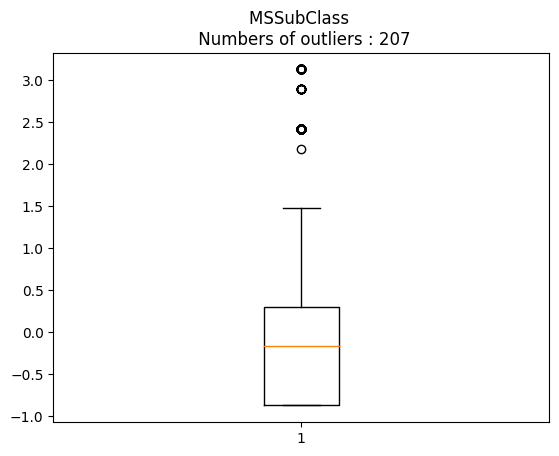

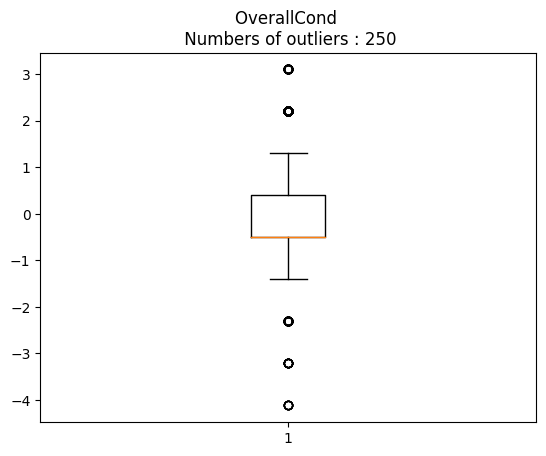

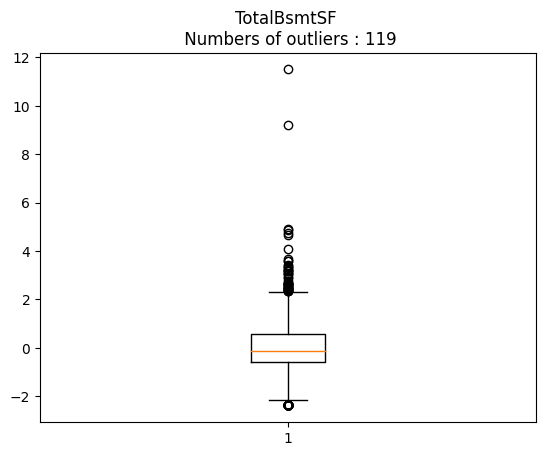

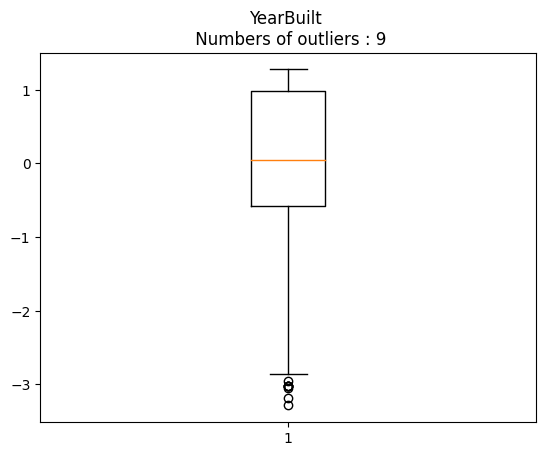

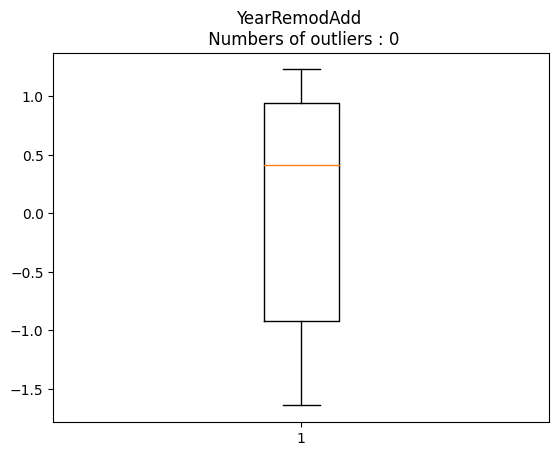

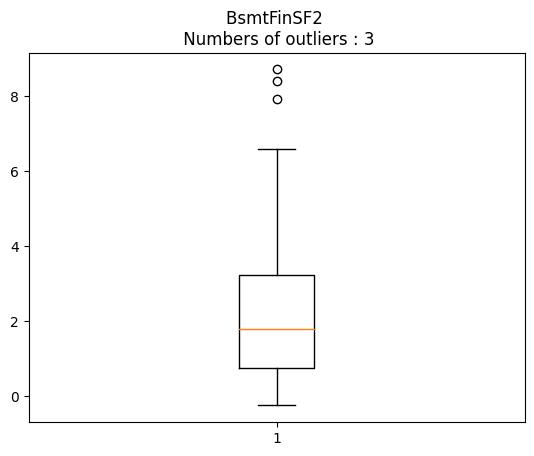

In [49]:
for col in columns_to_normalize.difference(["SalePrice", "BsmtFinSF2"]):
    plot_outliers(df[col])
    plot_outliers_with_matplotlib(df[col])

# Plot the box plot for the attribute "BsmtFinSF2" where the values is not 0
plot_outliers(df["BsmtFinSF2"][df["BsmtFinSF2"] != df["BsmtFinSF2"].median()])
plot_outliers_with_matplotlib(df["BsmtFinSF2"][df["BsmtFinSF2"] != df["BsmtFinSF2"].median()])

### 7.2 Question B (0.25 point)

**Traitez les données aberrantes identifiées à la question précédantes. Quel traitement appliquer ?**

Les attributs suivants ont des quantités non-négligeables de données abérrantes.
Nous ne pouvons pas simplement enlever les lignes ou remplacer les valeurs associées.
- LotArea 
- MSSubClass
- OverallCond
- TotalBsmtFT


In [51]:
def remove_outliers(dataset, alpha=1.5):
    q1, median, q3, lower_bound, upper_bound = get_bounds(dataset, alpha)

    data = dataset[(dataset > lower_bound) & (dataset < upper_bound)]

    # On n'enlève pas réellement les outliers, on affiche plutôt le boxplot des données sans les outliers
    # afin ne pas alterner les données.
    fig = go.Figure()

    fig.add_trace(
        go.Box(
            y=[data.values],
            name=data.name,
            boxpoints="outliers",
            q1=np.array(q1),
            median=np.array(median),
            q3=np.array(q3),
            lowerfence=np.array(lower_bound),
            upperfence=np.array(upper_bound),
            marker=dict(color="indianred", outliercolor="indianred"),
            line_color="rgb(107,174,214)",
            hoverinfo="y",
        )
    )

    fig.update_layout(
        title_text="{}".format(data.name),
        xaxis=dict(
            showticklabels=False,
        ),
    )

    fig.show()

def remove_outliers_with_matplotlib(dataset, alpha=1.5):
    q1, median, q3, lower_bound, upper_bound = get_bounds(dataset, alpha)
    data = dataset[(dataset > lower_bound) & (dataset < upper_bound)]
    plt.boxplot(data, showfliers=True)
    plt.title(f"{data.name}")
    plt.show()

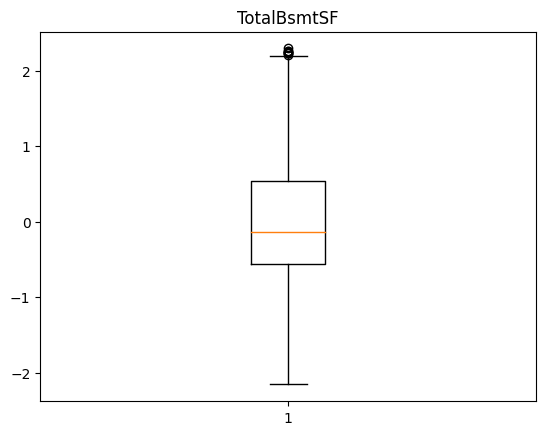

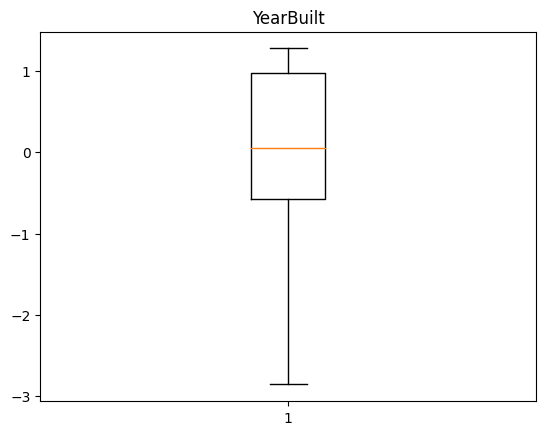

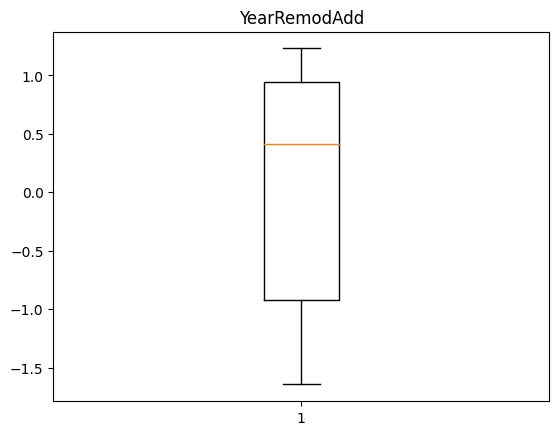

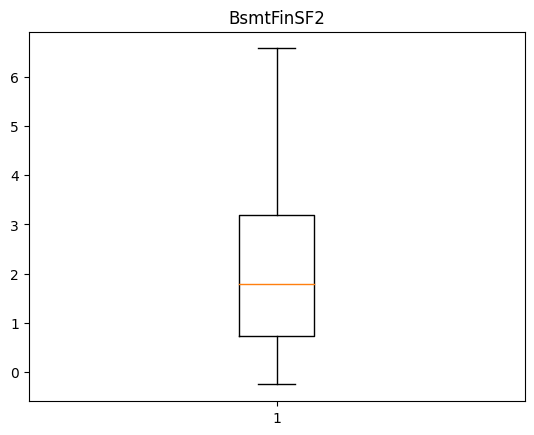

In [52]:
for col in columns_to_normalize.difference(
    ["SalePrice", "BsmtFinSF2", "LotArea",
        "MSSubClass", "OverallCond", "TotalBsmtFT"]
):
    remove_outliers(df[col], alpha=1.5)
    remove_outliers_with_matplotlib(df[col], alpha=1.5)

# Remove the outliers for "BsmtFinSF2" where the values is not 0
remove_outliers(df["BsmtFinSF2"][df["BsmtFinSF2"] != df["BsmtFinSF2"].median()], alpha=1.5)
remove_outliers_with_matplotlib(df["BsmtFinSF2"][df["BsmtFinSF2"] != df["BsmtFinSF2"].median()], alpha=1.5)